<a href="https://colab.research.google.com/github/jdmartinev/ST1613-AppliedML-/blob/main/Semana03/Ejemplo_Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Logística

En este cuaderno entrenaremos una regresión logística con regularización L2 y con características polinómicas, usando validación cruzada para seleccionar buenos hiperparámetros.

In [ ]:
import numpy as np
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, plot_confusion_matrix

In [ ]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [ ]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

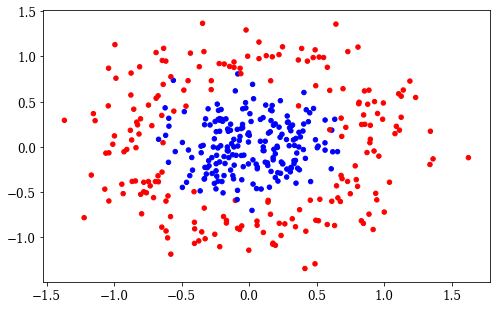

In [ ]:
# Definamos y grafiquemos nuestro dataset:
X, y = datasets.make_circles(n_samples=400, factor=0.3, noise=0.2, random_state=random_state)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, c=np.where(y == 0, 'r', 'b'))
fig.set_size_inches(1.6*5, 5)

In [ ]:
# Separemos nuestros datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
# Función auxiliar para graficar la frontera de decisión:

def plot_binary_classifcation(X, y, classifier=None, contour_alpha=0.1):
    
    def compute_predictions(X, classifier):
        return classifier.predict(X)
    
    cmap = ListedColormap(['#FF0000', '#0000FF'])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01)
    )
    
    fig, ax = plt.subplots()
    
    if classifier is not None:
        X_ = np.array([xx1.ravel(), xx2.ravel()]).T
    
        z = compute_predictions(X_, classifier)
        z = np.reshape(z, xx1.shape)
        ax.contourf(xx1, xx2, z, alpha=contour_alpha, cmap=cmap)
    
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
    
    fig.set_size_inches(1.6*5, 5)

In [ ]:
# Definamos un pipeline de scikit-learn con nuestro modelo base:
lr_base = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1e5))
])

In [ ]:
# Definamos las distribuciones de parámetros sobre las que haremos la búsqueda:
param_distributions = {
    'poly__degree': list(range(2, 8)),
    'classifier__C': reciprocal(1e-5, 1e5)
}

In [ ]:
# Definamos nuestro modelo mediante RandomizedSearchCV:

lr = RandomizedSearchCV(
    lr_base,
    cv=4,
    param_distributions=param_distributions,
    n_iter=200,
    random_state=random_state
)

In [ ]:
%%time
# Entrenemos el modelo:
lr.fit(X_train, y_train)

Wall time: 8.4 s


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              LogisticRegression(max_iter=100000.0))]),
                   n_iter=200,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CCBDCE5220>,
                                        'poly__degree': [2, 3, 4, 5, 6, 7]},
                   random_state=42)

In [ ]:
# Obtengamos los mejores hiperparámetros encontrados para el modelo:
lr.best_params_

{'classifier__C': 17.09941561344385, 'poly__degree': 3}

In [ ]:
# Obtengamos la accuracy y el f1-score de prueba:
print(f'Accuracy: {lr.score(X_test, y_test)}')
print(f'F1 score: {f1_score(y_test, lr.predict(X_test))}')

Accuracy: 0.8875
MAE: 0.8860759493670887


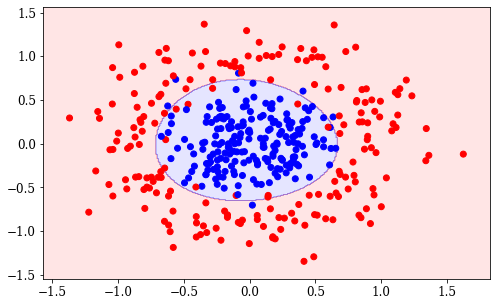

In [ ]:
# Grafiquemos los datos junto con la frontera de decisión del modelo:
plot_binary_classifcation(X, y, classifier=lr)

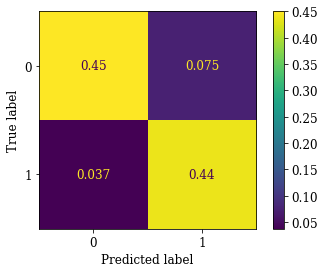

In [ ]:
# Grafiquemos la matriz de confusión de los datos de prueba:
plot_confusion_matrix(lr, X_test, y_test, normalize='all')